# 算法链与管道

`
创建于20230313 创建者Stephen CUI
`

In [49]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
import mglearn

In [15]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print('Test score: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


## 用预处理进行参数选择

In [16]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print('Best cross-validation accuracy: {:.2f}'.format(grid.best_score_))
print('Best set score: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('Best parameter:', grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameter: {'C': 1, 'gamma': 1}


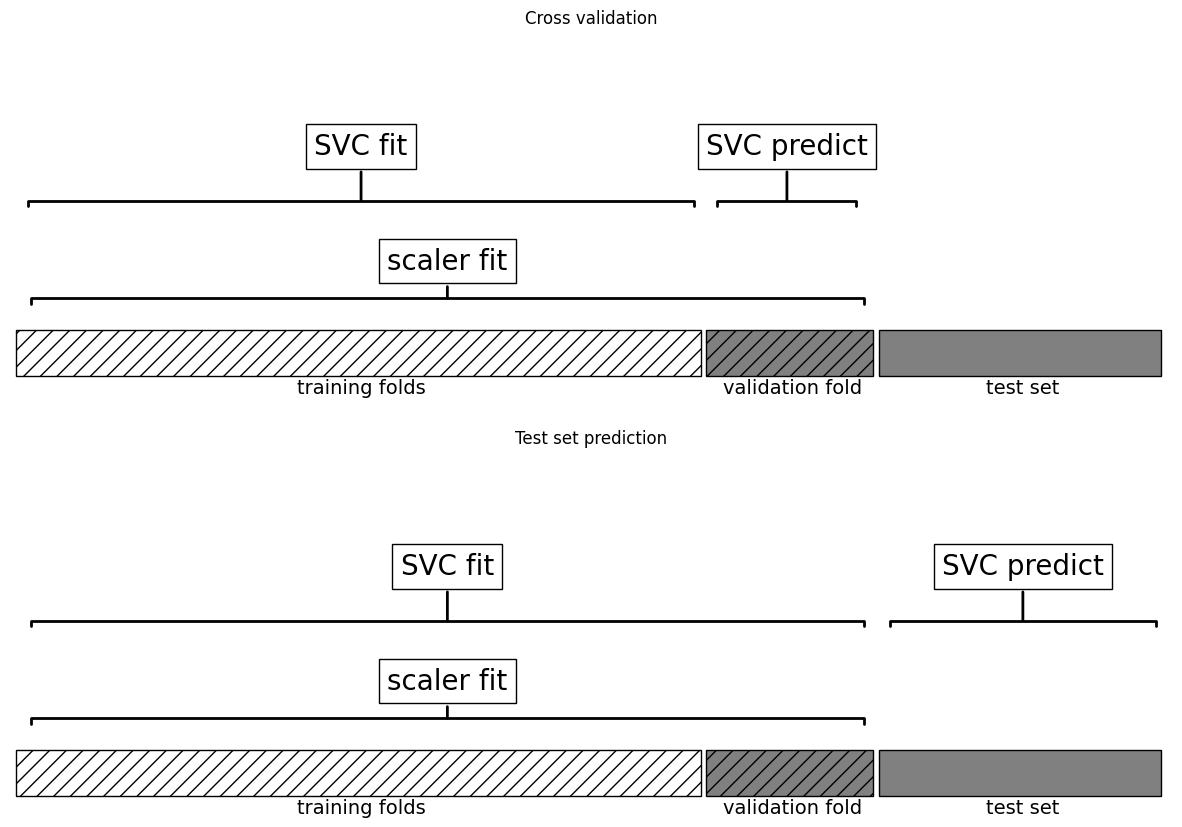

In [18]:
mglearn.plots.plot_improper_processing()

## 构建管道

In [21]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [22]:
print('Test set score: {:.2f}'.format(pipe.score(X_test, y_test)))

Test set score: 0.97


## 在网格搜索中使用管道

In [28]:
param_grid = {'svm__C': [.001, .01, .1, 1, 10, 100],
              'svm__gamma': [.001, .01, .1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best cross-validation accuracy: {:.2f}'.format(grid.best_score_))
print('Test set score: {:.2f}'.format(grid.score(X_test, y_test)))
print('Best parameters: {}'.format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


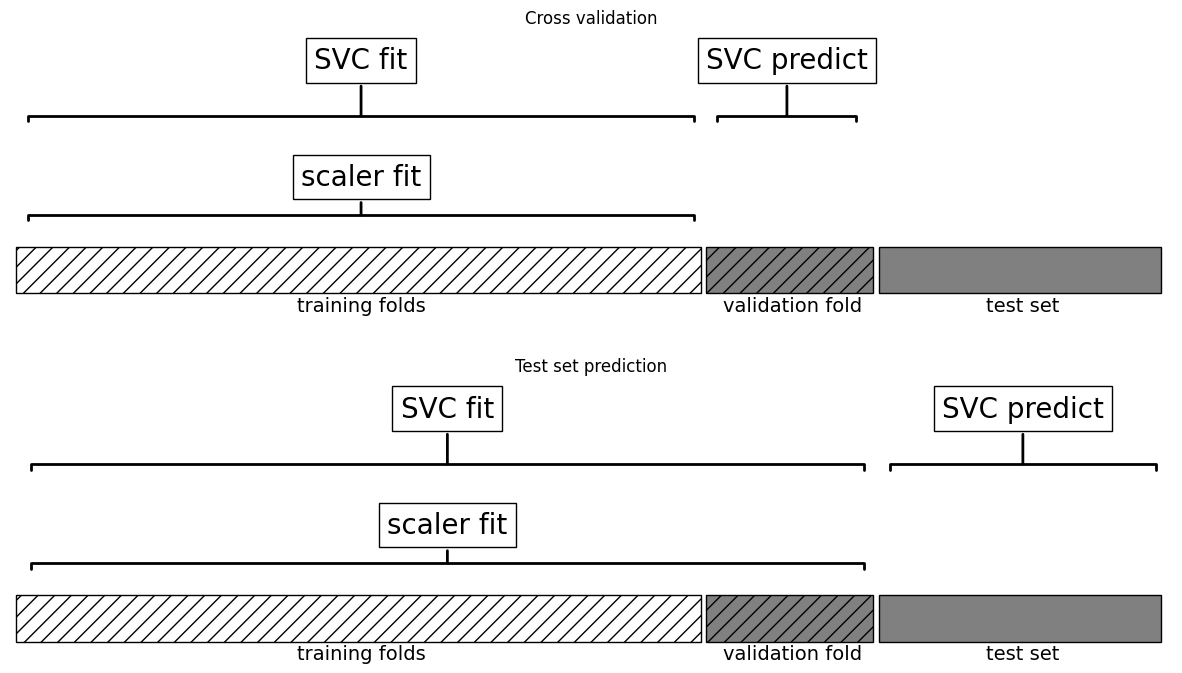

In [29]:
mglearn.plots.plot_proper_processing()

In [39]:
rng = np.random.RandomState(seed=0)
X = rng.normal(size=(100, 10_000))
y = rng.normal(size=(100,))

考虑到我们创建数据集的方式，数据 X 与目标 y 之间没有任何关系（它们是独立的），
所以应该不可能从这个数据集中学到任何内容。现在我们将完成下列工作。首先利用
SelectPercentile 特征选择从 10 000 个特征中选择信息量最大的特征，然后使用交叉
验证对 Ridge 回归进行评估：

In [40]:
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_selected.shape: {}'.format(X_selected.shape))

X_selected.shape: (100, 500)


In [41]:
print('Cross-validation accuracy (cv only on ridge): {:.2f}'.format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))
))

Cross-validation accuracy (cv only on ridge): 0.91


交叉验证计算得到的平均 $R^2$ 为 0.91，表示这是一个非常好的模型。这显然是不对的，
因为我们的数据是完全随机的。这里的特征选择从 10 000 个随机特征中（碰巧）选出
了与目标相关性非常好的一些特征。由于我们在交叉验证之外对特征选择进行拟合，
所以它能够找到在训练部分和测试部分都相关的特征。从测试部分泄露出去的信息包
含的信息量非常大，导致得到非常不切实际的结果。我们将这个结果与正确的交叉验
证（使用管道）进行对比：

In [45]:
pipe = Pipeline([
    ('select', SelectPercentile(score_func=f_regression, percentile=5)),
    ('ridge', Ridge())
])
print('Cross-validation accuracy (pipeline): {:.2f}'.format(
    np.mean(cross_val_score(pipe, X, y, cv=5))
))

Cross-validation accuracy (pipeline): -0.25


这一次我们得到了负的 $R^2$ 分数，表示模型很差。利用管道，特征选择现在位于交叉验
证循环内部。也就是说，仅使用数据的训练部分来选择特征，而不使用测试部分。特
征选择找到的特征在训练集中与目标相关，但由于数据是完全随机的，这些特征在测
试集中并不与目标相关。在这个例子中，修正特征选择中的数据泄露问题，结论也由
“模型表现很好”变为“模型根本没有效果”。

## 通用的管道接口

### 用make_pipeline方便地创建管道

In [3]:
pipe_long = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC(C=100))
])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [12]:
print('Pipeline steps: \n{}'.format(pipe_short.steps))

Pipeline steps: 
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [13]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

### 访问步骤属性

In [19]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
components.shape

(2, 30)

### 访问网格搜索管道中的属性

In [25]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1_000))

param_grid = {'logisticregression__C': [.01, .1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4
)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [28]:
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])

我们可以使用管道的 named_steps 属性来访问 logisticregression 步骤

In [29]:
grid.best_estimator_.named_steps['logisticregression']

LogisticRegression(C=1, max_iter=1000)

In [30]:
grid.best_estimator_.named_steps['logisticregression'].coef_

array([[-0.43570655, -0.34266946, -0.40809443, -0.5344574 , -0.14971847,
         0.61034122, -0.72634347, -0.78538827,  0.03886087,  0.27497198,
        -1.29780109,  0.04926005, -0.67336941, -0.93447426, -0.13939555,
         0.45032641, -0.13009864, -0.10144273,  0.43432027,  0.71596578,
        -1.09068862, -1.09463976, -0.85183755, -1.06406198, -0.74316099,
         0.07252425, -0.82323903, -0.65321239, -0.64379499, -0.42026013]])

## 网格搜索预处理步骤与模型参数

In [34]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
boston = load_boston()

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()
)

c:\Users\19243\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the

我们怎么知道选择几次多项式，或者是否选择多项式或交互项呢？理想情况下，我们希望
根据分类结果来选择 degree 参数。我们可以利用管道搜索 degree 参数以及 Ridge 的 alpha
参数。

In [46]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3],
    'ridge__alpha': [.001, .01, .1, 1, 10, 100]
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

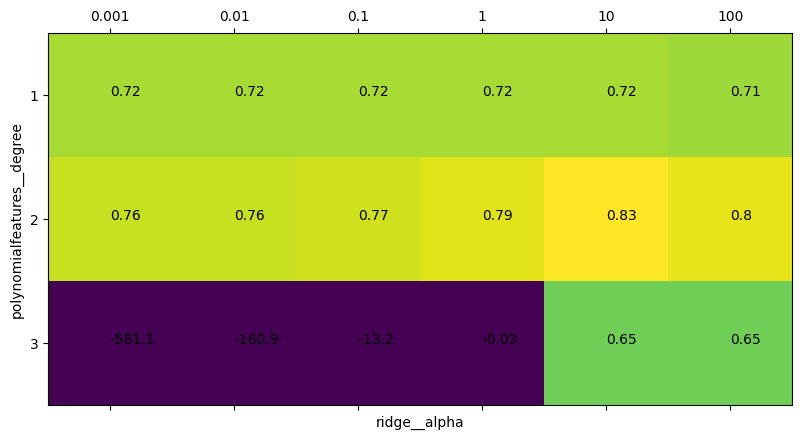

In [68]:
mean_test_score = np.around(grid.cv_results_['mean_test_score'].reshape(3, -1), 2)
plt.matshow(mean_test_score, vmin=0)
plt.xlabel('ridge__alpha')
plt.ylabel('polynomialfeatures__degree')
plt.xticks(range(len(param_grid['ridge__alpha'])), 
           param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])
for degree in range(len(param_grid['polynomialfeatures__degree'])):
    for alpha in range(len(param_grid['ridge__alpha'])):
       plt.text(alpha, degree, mean_test_score[degree, alpha])
plt.show()

In [69]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}

In [72]:
print('Test set score: {:.2f}'.format(grid.score(X_test, y_test)))

Test set score: 0.77


In [76]:
param_grid = {'ridge__alpha': [.001, .01, .1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
round(grid.score(X_test, y_test), 2)

0.63

## 网格搜索选择使用哪个模型

In [77]:
pipe = Pipeline([
    ('preprocessing', StandardScaler()),
    ('classifier', SVC())
])

In [91]:
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {'classifier': [SVC()],
     'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [.001, .01, .1, 1, 10, 100]
     },
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None],
     'classifier__max_features': [1, 2, 3]}
]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(gamma=0.01)],
                          'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler(), None]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features': [1, 2, 3],
                          'preprocessing': [None]}])

In [93]:
grid.best_params_

{'classifier': SVC(gamma=0.01),
 'classifier__gamma': 0.01,
 'preprocessing': StandardScaler()}

In [94]:
grid.best_score_

0.9695212038303694

In [95]:
grid.score(X_test, y_test)

0.958041958041958